# Coronavirus
Statistics about coronavirus in Czechia.  
Filip Gregor, 2020 

In [320]:
tests = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/nakazeni-vyleceni-umrti-testy.csv"
daily_cases = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.csv"

Import python libraries

In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as numpy
from lmfit.models import ExponentialModel
from lmfit.models import StepModel

Read the data and save them into panda dataframe.

In [322]:
corona = pd.read_csv(tests)
# Translate column headers into english. 
corona = corona.rename({
    'datum' : 'date',
    'kumulativni_pocet_nakazenych' : 'positive_acc',
    'kumulativni_pocet_vylecenych' : 'cured',
    'kumulativni_pocet_umrti' : 'deaths',
    'kumulativni_pocet_testu' : 'tests',
}, axis = 1)
corona.head()

,date,positive_acc,cured,deaths,tests
0,2020-01-27,0,0,0,20
1,2020-01-28,0,0,0,28
2,2020-01-29,0,0,0,33
3,2020-01-30,0,0,0,34
4,2020-01-31,0,0,0,37


Change the 'date' column into datetime datatype, sort values by date and reset indexes.

In [323]:
# Convert date to datetype 
corona['date'] = pd.to_datetime(corona['date'], format='%Y-%m-%d')

# Sort values by date and reset indexes
corona.sort_values('date')
corona = corona.reset_index(drop=True)
corona.tail()

,date,positive_acc,cured,deaths,tests
190,2020-08-04,17282,12458,387,722108
191,2020-08-05,17523,12543,388,728800
192,2020-08-06,17737,12639,389,735614
193,2020-08-07,18060,12761,389,743589
194,2020-08-08,18235,12765,389,743589


Create new column with daily cases and daily tests, also one with total cases at one time(total_acc - cured).

In [324]:
corona['positive_curr'] = corona['positive_acc'] - corona['cured']
corona['daily_positives'] = corona['positive_acc'] - corona['positive_acc'].shift(1)
corona['daily_tests'] = corona['tests'] - corona['tests'].shift(1)
corona.tail()

,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests
190,2020-08-04,17282,12458,387,722108,4824,289.0,8144.0
191,2020-08-05,17523,12543,388,728800,4980,241.0,6692.0
192,2020-08-06,17737,12639,389,735614,5098,214.0,6814.0
193,2020-08-07,18060,12761,389,743589,5299,323.0,7975.0
194,2020-08-08,18235,12765,389,743589,5470,175.0,0.0


Remove leading rows with zero cases and remove last row, because it often has incomplete data.

In [361]:
corona_Pmask = corona['daily_positives'] > 0

# Count how many leading rows have 0 cases, stop when we encounter a row that has cases.
count = 0
for x in corona_Pmask:
    if x:
        break
    count += 1
    
# Remove first 'count' rows.
corona = corona.iloc[count:]

# Remove last row, it often has incomplete number of tests.
corona = corona[:-1]

# Reset indexes.
corona = corona.reset_index(drop=True)
corona['day'] = corona.index

# Convert columns to numeric.
numeric_columns = corona.columns.drop('date')
corona[numeric_columns] = corona[numeric_columns].apply(pd.to_numeric)

corona.info()
corona

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             145 non-null    datetime64[ns]
 1   positive_acc     145 non-null    int64         
 2   cured            145 non-null    int64         
 3   deaths           145 non-null    int64         
 4   tests            145 non-null    int64         
 5   positive_curr    145 non-null    int64         
 6   daily_positives  145 non-null    float64       
 7   daily_tests      145 non-null    float64       
 8   day              145 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 10.3 KB


,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests,day
0,2020-03-01,3,0,0,211,3,3.0,11.0,0
1,2020-03-02,3,0,0,262,3,0.0,51.0,1
2,2020-03-03,5,0,0,340,5,2.0,78.0,2
3,2020-03-04,6,0,0,407,6,1.0,67.0,3
4,2020-03-05,9,0,0,483,9,3.0,76.0,4
...,...,...,...,...,...,...,...,...,...
140,2020-07-19,13959,11272,359,626610,2687,91.0,1830.0,140
141,2020-07-20,14128,11391,359,632395,2737,169.0,5785.0,141
142,2020-07-21,14334,11483,361,638484,2851,206.0,6089.0,142
143,2020-07-22,14579,11584,363,645093,2995,245.0,6609.0,143


# Simple Graphs

### Positive cases

Text(0.5, 1.0, 'Positive cases')

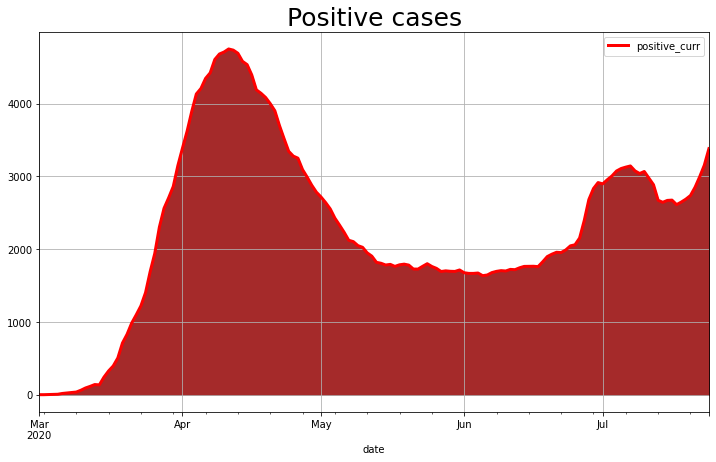

In [351]:
ax = corona.plot(x='date', y='positive_curr', figsize=(12,7), grid=True, lw=3, color='red')

# Pandas does not convert pandas series of datetime64 conversion, so matplotlib does not recognize
# it, thats why we're creating a numpy array, source: https://stackoverflow.com/questions/29329725/pandas-and-matplotlib-fill-between-vs-datetime64
d = corona['date'].values

ax.fill_between(d,  0, corona['positive_curr'], color='brown')
ax.set_title("Positive cases", fontsize=25) 

### Tests done.

Text(0.5, 1.0, 'Tests done')

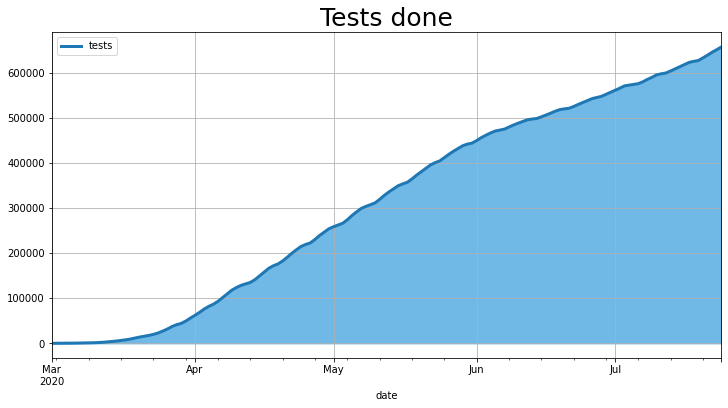

In [352]:
ax = corona.plot(x='date', y='tests', figsize=(12,6), grid=True, lw=3)

ax.fill_between(d, 0, corona['tests'], color='#70b9e6')
ax.set_title('Tests done', fontsize=25)

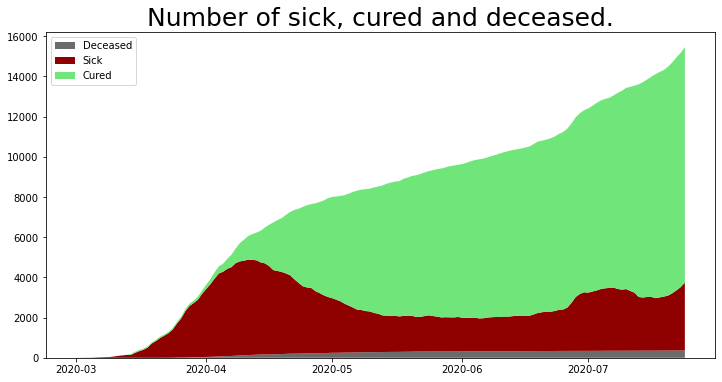

In [353]:
colors = ['#6b6b6b','#8f0101','#70e67a']
fig, ax = plt.subplots(figsize=(12,6))
ax.stackplot(d, corona['deaths'], corona['positive_curr'], corona['cured'], labels=('Deceased', 'Sick', 'Cured'), colors=colors)
ax.legend(loc='upper left')
ax.set_title('Number of sick, cured and deceased.', fontsize=25)
plt.show()

Positive cases in logarithmic scale.

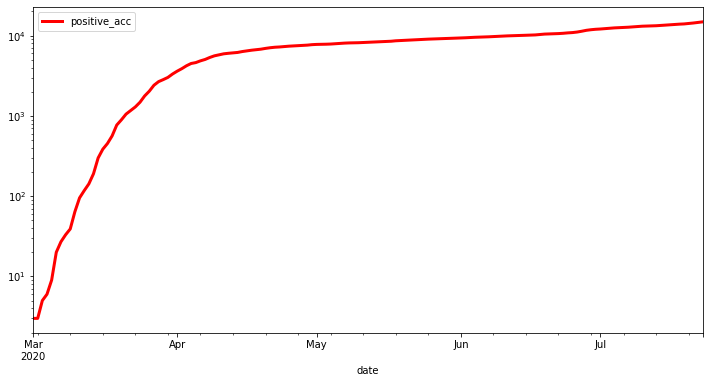

In [363]:
corona.plot(x='date', y='positive_acc', color='red', figsize=(12,6),lw=3, logy=True)

## Exponential growth.
Plot exponential through the data and check if it still grows exponentially.
Inspired by https://kam.fit.cvut.cz/deploy/coronavirus/ by Tomáš Kalvoda.

In [400]:
from lmfit.models import ExponentialModel

We will use the 'exponential decay' function. Lets briefly analyze it first.
$$ amplitude \cdot e^{-x/decay} $$

In [418]:
def exp_decay(x, ampl, decay):
    return ampl * np.exp(-x / decay)

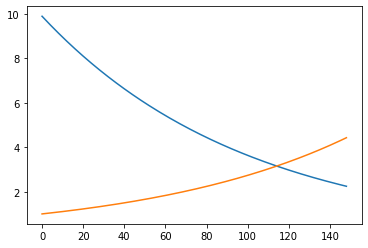

In [443]:
exp_values_neg = [exp_decay(x, 1, -100) for x in range(1, 150)]
exp_values = [exp_decay(x, 10, 100) for x in range(1, 150)]

plt.plot(range(0,len(exp_values)), exp_values)
plt.plot(range(0,len(exp_values_neg)), exp_values_neg)
plt.show()

We will need to use negative decay to make the function grow. Also amplitude will have to be way bigger.

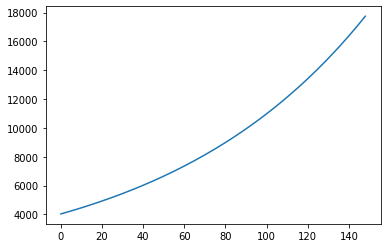

In [449]:
sugg_ampl, sugg_decay = 4000, -100
exp_values_neg = [exp_decay(x, sugg_ampl, sugg_decay) for x in range(1, 150)]
plt.plot(range(0, len(exp_values_neg)), exp_values_neg)
plt.show()

Now, we need to give curve_fit a push to make it work, lets give it the values we guessed as a starting point.

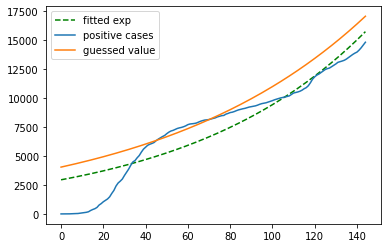

Amplitude: 2945.0302199472017, Decay: -85.96949993008444


In [453]:
popt, pcov = curve_fit(func, corona['day'].to_numpy(), corona['positive_acc'].to_numpy(), p0=[sugg_ampl, sugg_decay])
plt.plot(corona['day'], exp_decay(corona['day'], *popt), 'g--', label='fitted exp')
plt.plot(corona['day'], corona['positive_acc'], label='positive cases')
plt.plot(corona['day'], exp_values_neg[:len(corona.index)], label='guessed value')
plt.legend()
plt.show()
print("Amplitude: {}, Decay: {}".format(popt[0], popt[1]))


Quotient by which positive cases go up every day.

In [459]:
q=np.exp(-1/popt[1])
q

1.0116999474626973

Which is approx.

In [469]:
print( '{:.2f}% increase every day'.format((q - 1) * 100))

1.17% increase every day
